In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
archivo_entrada = '2023.csv'

In [3]:
df=pd.read_csv(archivo_entrada)

El dataset cargado corresponde con los datos de predicción meteorológica de datos maritimos dados por el modelo de holas WAM del ECMWF. En el se encuentran los valores de direccion de viento (dwi), la fuerzza del viento (wind), la altura significativa del mar de viento (significant height of wind waves o shww), la direccion media del mar de fondo total (mean direction of the total swell o mdts) y la altura significativa del mar de fondo total (shts), dados para unos valores de latitud y longuitud correspondientes aproximadamente con las aguas costeras de cantabria, de uso operativo, durante el año 2023, dados cada 3 horas. Los valores de direccion del mar de viento no se dan, ya que se suponen iguales al del viento en ese instante y lugar. Asi, disponemos de mas de 11000 datos para cada variable. 

In [4]:
df[['dwi', 'wind', 'shww', 'mdts', 'shts']].describe()

,dwi,wind,shww,mdts,shts
count,117568.000000,117568.000000,1.175680e+05,117568.000000,117568.000000
mean,185.505328,5.657169,6.353184e-01,302.589724,1.494781
std,105.643296,3.520784,1.010862e+00,56.935928,0.895067
min,0.005363,1.000000,3.410955e-16,0.000410,0.002559
25%,86.405763,3.074219,9.867627e-02,300.369997,0.863086
50%,196.695555,4.926758,2.710615e-01,311.279750,1.318808
75%,283.796205,7.392578,6.761780e-01,321.840158,1.876983
max,359.985400,24.574219,9.143180e+00,360.001340,6.513699


Hay que tener en cuenta que tenemos 3 variables numericas (wind, shww y shts) y 2 variables angulares (dwi y mdts). Sobre las variables numericas, podemos calcular medias, maximos, minimos y otro tipo de calculos estadisticos. Sin embargo, debido al caracter ciclico de las variables angulares, no tendra sentido el calculo de maximos y minimos. Para calculo de angulos medios, tendremos que pasar estos valores a sus proyecciones direccionales a traves del seno y el coseno, siendo aun asi mas representativo de la direccionalidad de los campos un estudio frecuentista discreto, como veremos.
Con el fin de poder calcular angulos medios directamente del dataset, construimos 2 funciones que pasen del valor angular a su proyeccion direccional.

In [5]:
variables_no_agrup=['cos_dwi', 'sin_dwi', 'wind', 'shww', 'cos_mdts', 'sin_mdts', 'shts']
variables_agrup = ['dwi', 'wind', 'shww', 'mdts', 'shts']

def proyectar_angulo(df, var):
    df[f'cos_{var}'] = np.cos(np.radians(df[var]))
    df[f'sin_{var}'] = np.sin(np.radians(df[var]))
    df.drop(var, axis=1, inplace=True)

def reconstruir_angulo(df, var):
    df[f'rad_{var}'] = np.arctan2(df[f'sin_{var}'], df[f'cos_{var}'])
    df[var] = np.degrees(df[f'rad_{var}'])
    df[var] = df[var] % 360
    df.drop([f'sin_{var}', f'cos_{var}', f'rad_{var}'], axis=1, inplace=True)

Usando estas funciones antes descritas. podemos calcular el angulo medio como:

In [6]:
proyectar_angulo(df, 'dwi')
proyectar_angulo(df, 'mdts')

In [7]:

df_describe = df[variables_no_agrup].describe()
reconstruir_angulo(df_describe, 'dwi')
df_describe['dwi']['mean']

335.9334985001059

Este metodo es util para calcular el angulo medio, pero no cuantiles o medidas de dispersion. Vayamos ahora con un estudio general de las variables que se contienen en este dataset

-Estudio de la serie temporal, con promedio longuitudinal y latitudinal

A continuacion estudiaremos la serie temporal de las variables contenidas en el dataset, habiendo promediado longuitudinal y latitudinalmente. En apartados posteriores estudiaremos en profundidad la distribucion espacial de las mismas. Para realizar el estudio temporal, la primera alternativa es a traves del uso de resample. Esta funcion nos permite modificar el granulo del indice temporal, promediando el resto de indices del dataset, en dataset multiindices. Asi, para realizar un promedio espacial usando resample, tendremos que marcar como indices del dataset 'date', 'latitude' y 'longitude', y realizar un promedio horario, eliminando los valores que no contengan valores numericos NaN, en las horas donde no habia datos iniciales. Asi:


In [8]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date', 'latitude', 'longitude'], inplace=True)

df_espacial_horario = df.resample('h', level='date').mean()
df_espacial_horario.dropna(inplace=True)
print(df_espacial_horario)
df.reset_index(inplace=True)
df_espacial_horario.reset_index(inplace=True)



                         wind      shww      shts   cos_dwi   sin_dwi  \
date                                                                    
2023-01-01 12:00:00  9.143089  0.791690  1.795122 -0.841358  0.336014   
2023-01-01 15:00:00  5.653387  0.418501  1.902019 -0.618965 -0.133774   
2023-01-01 18:00:00  5.367409  0.233048  2.002645  0.545066 -0.757585   
2023-01-01 21:00:00  4.823109  0.304057  2.050939  0.316120 -0.919114   
2023-01-02 00:00:00  6.488614  0.638832  1.996466  0.369265 -0.926178   
...                       ...       ...       ...       ...       ...   
2023-11-30 21:00:00  9.025346  1.262321  1.419520  0.076137 -0.989283   
2023-12-01 00:00:00  8.637340  1.218473  1.662913  0.040825 -0.984910   
2023-12-01 03:00:00  8.417991  1.167458  1.825269  0.041106 -0.976947   
2023-12-01 06:00:00  8.613548  1.095932  2.017810 -0.069961 -0.966042   
2023-12-01 09:00:00  9.347457  1.202115  2.090789 -0.082655 -0.973432   

                     cos_mdts  sin_mdts  
date    

Ademas, como hemos visto, podemos usar reshape para modificar el granulo espacial de los datos, promediando diariamente, semanalmente o mensualmente. Asi:

In [9]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date', 'latitude', 'longitude'], inplace=True)

df_espacial_diario = df.resample('d', level='date').mean()
df_espacial_semanal = df.resample('W', level='date').mean()
df_espacial_mensual = df.resample('ME', level='date').mean()

df.reset_index(inplace=True)
df_espacial_diario.reset_index(inplace=True)
df_espacial_semanal.reset_index(inplace=True)
df_espacial_mensual.reset_index(inplace=True)
print(df_espacial_mensual)

         date      wind      shww      shts   cos_dwi   sin_dwi  cos_mdts  \
0  2023-01-31  6.934698  1.081767  2.257397  0.088856 -0.201442  0.665788   
1  2023-02-28  5.944601  0.565166  1.651581  0.005363  0.316315  0.680301   
2  2023-03-31  5.368444  0.587545  1.867290 -0.057476 -0.082292  0.527608   
3  2023-04-30  5.553030  0.638276  1.369395  0.109097  0.013960  0.597583   
4  2023-05-31  5.255838  0.451359  1.146023  0.361535 -0.171407  0.730622   
5  2023-06-30  4.202195  0.253701  0.639267  0.289437  0.067645  0.770732   
6  2023-07-31  4.521938  0.362269  1.191582  0.305961 -0.181390  0.703379   
7  2023-08-31  5.592042  0.604886  1.128330  0.341684 -0.096010  0.717552   
8  2023-09-30  4.920523  0.419734  1.362411 -0.005056  0.115208  0.660370   
9  2023-10-31  6.165986  0.685648  1.663662 -0.216853  0.075289  0.596142   
10 2023-11-30  7.761868  1.333268  2.172562  0.000790 -0.357660  0.674501   
11 2023-12-31  8.754084  1.170994  1.899196 -0.017671 -0.975333  0.678623   

Asi, podemos plotear dichas series y analizar sus resultados.

In [10]:
reconstruir_angulo(df_espacial_horario, 'dwi')
reconstruir_angulo(df_espacial_diario, 'dwi')
reconstruir_angulo(df_espacial_semanal, 'dwi')
reconstruir_angulo(df_espacial_mensual, 'dwi')
reconstruir_angulo(df_espacial_horario, 'mdts')
reconstruir_angulo(df_espacial_diario, 'mdts')
reconstruir_angulo(df_espacial_semanal, 'mdts')
reconstruir_angulo(df_espacial_mensual, 'mdts')

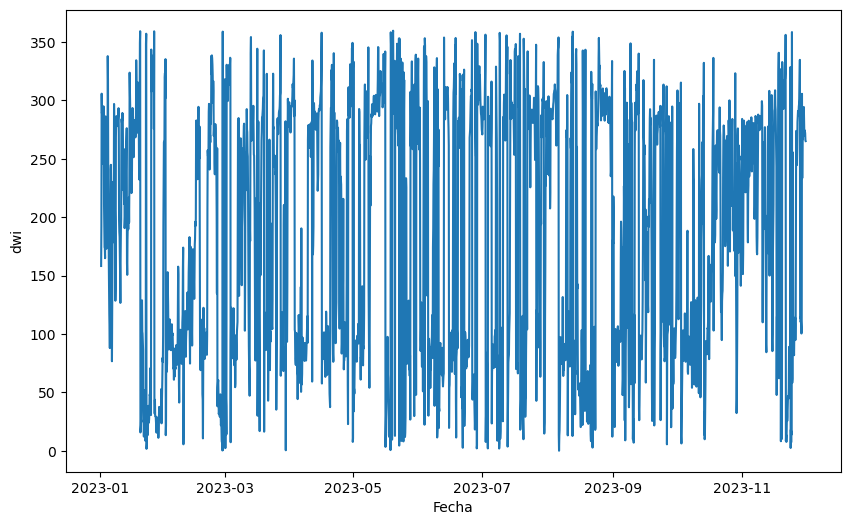

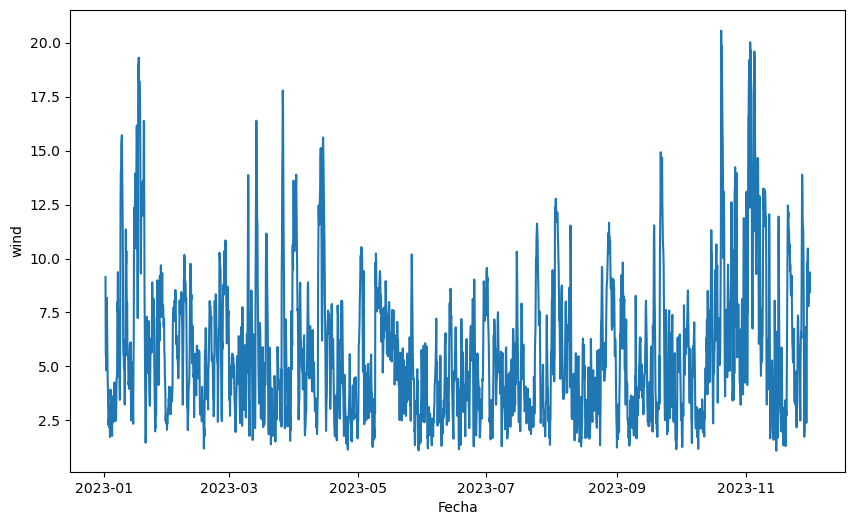

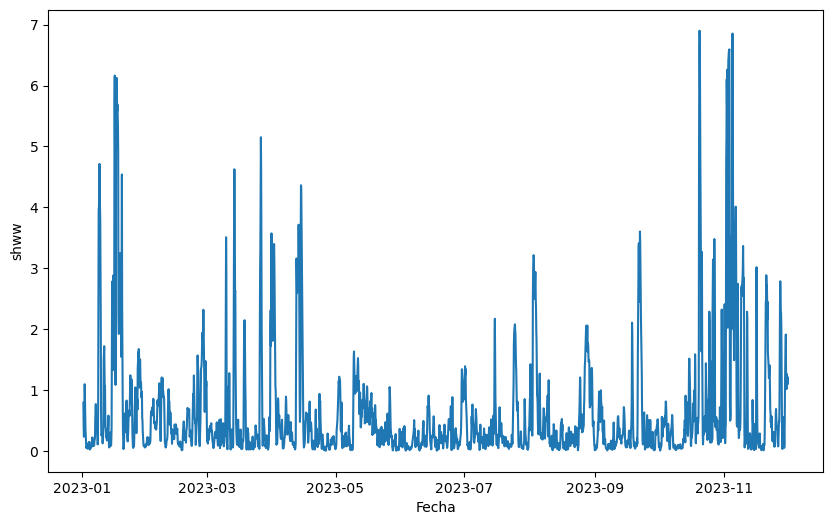

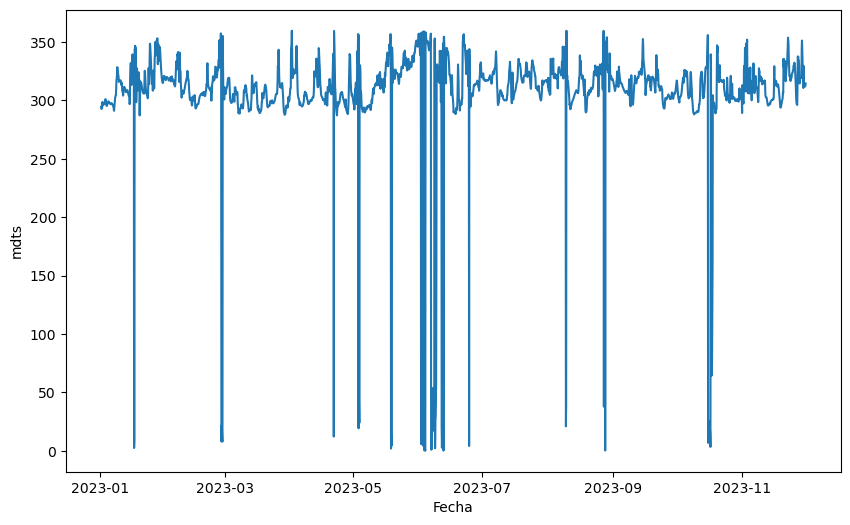

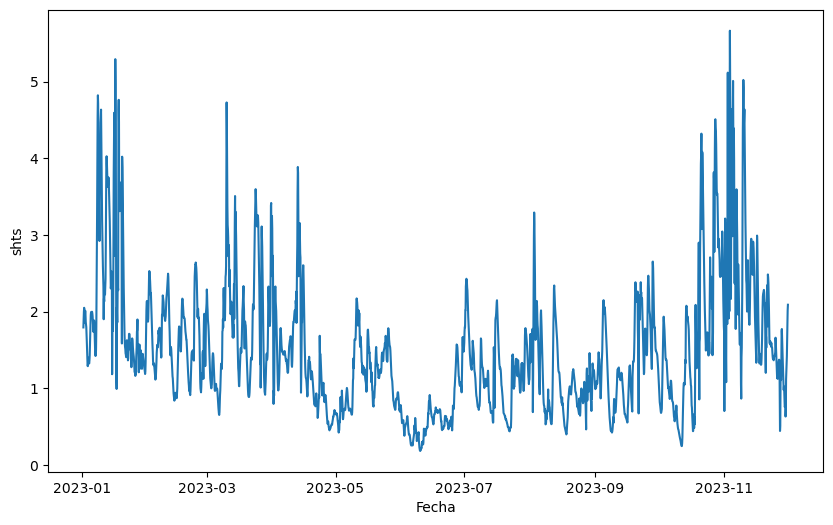

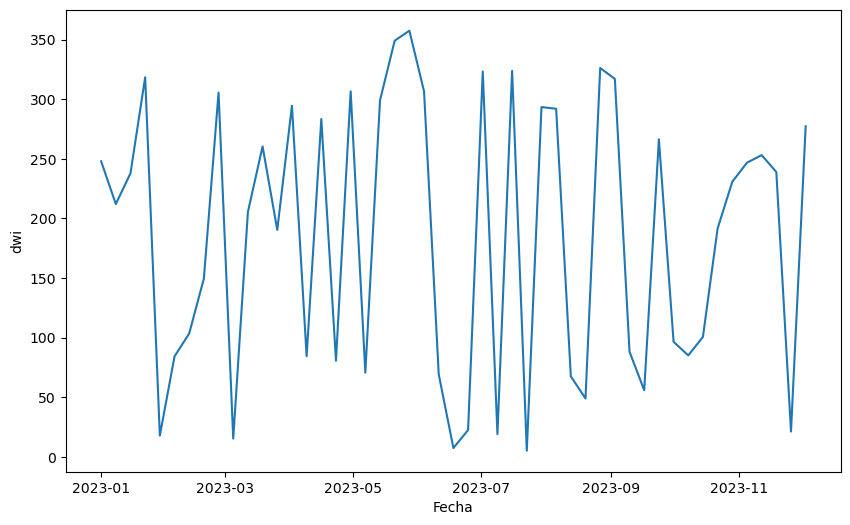

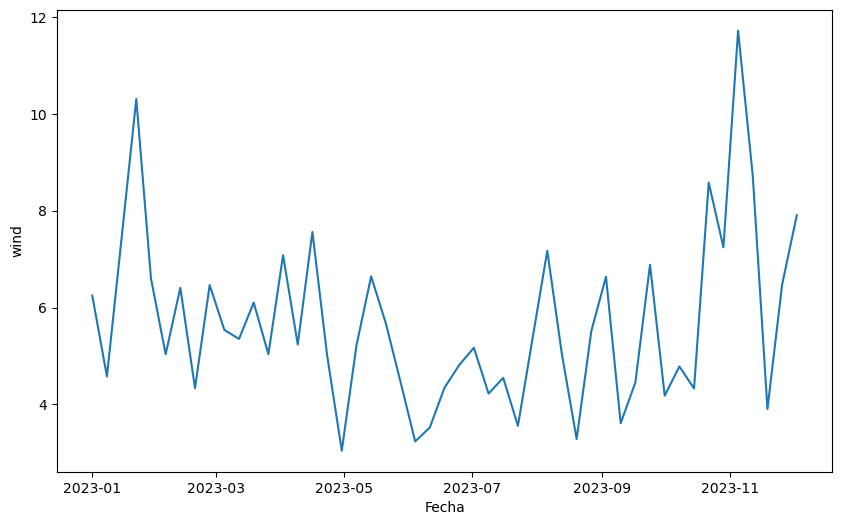

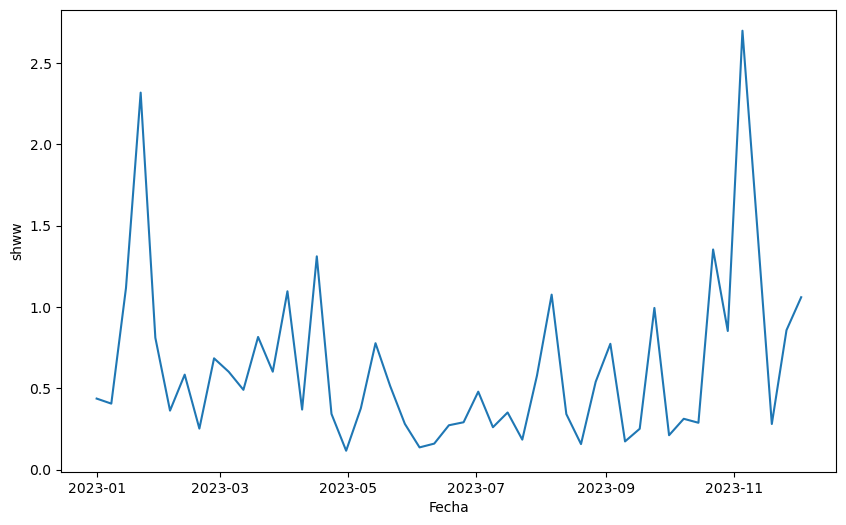

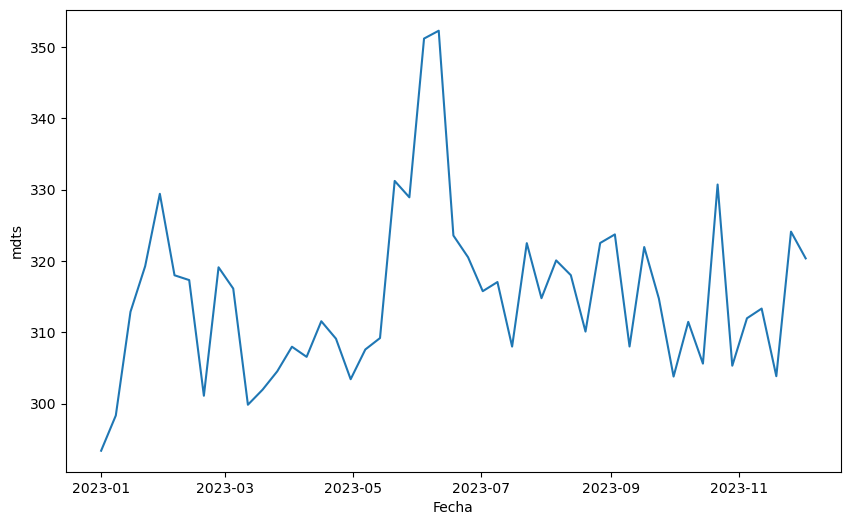

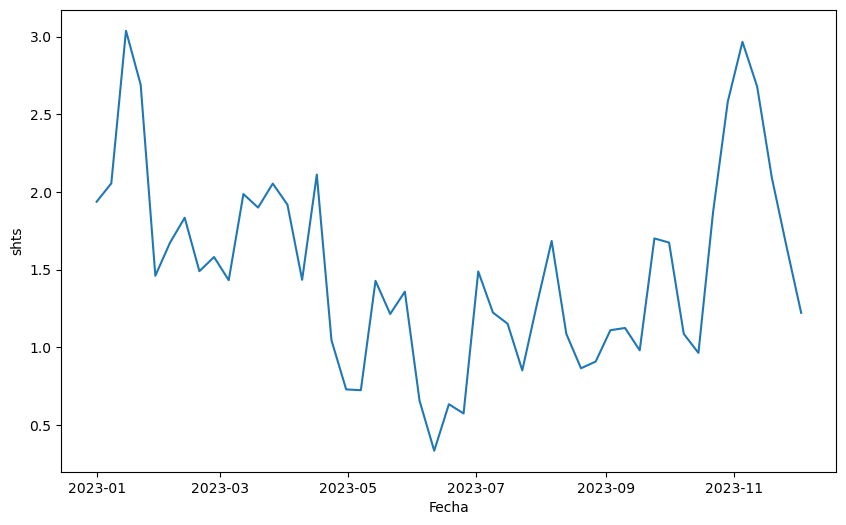

In [11]:
for var in variables_agrup:
    plt.figure(figsize=(10,6))
    plt.plot(df_espacial_horario['date'], df_espacial_horario[f'{var}'], label=f'{var}')
    plt.ylabel(var)
    plt.xlabel('Fecha')
    plt.show()
for var in variables_agrup:
    plt.figure(figsize=(10,6))
    plt.plot(df_espacial_semanal['date'], df_espacial_semanal[f'{var}'], label=f'{var}')
    plt.ylabel(var)
    plt.xlabel('Fecha')
    plt.show()

Aqui puede verse la representacion de las variables anteriores, ya sean sus valores horarios o su promedio semanal. Los crecimientos del valor de viendo, mar de viento y mar de fondo corresponte al paso de los distintos sistemas frontales, menos intensos en el periodo estival. La direccion del viento tiende a alinearse en 2 estados alternativos NW y NE, mientras que la direccion del mar de fondo es siempre del N o NW. El promedio semanal ayuda a eliminar el ruido presente en la serie horaria. Otra forma de eliminar este ruido es a traves de la funcion rolling, que calcula una media movil de una variable de tamaño a especificar. Asi, podemos aplicar una media movil de 3 o 4 dias, que es el periodo medio de paso de un sistema frontal:

In [12]:
proyectar_angulo(df_espacial_diario, 'dwi')
proyectar_angulo(df_espacial_diario, 'mdts')

In [13]:
df['date'] = pd.to_datetime(df['date'])

df_espacial_diario.reset_index(inplace=True)

df_espacial_diario.set_index('date', inplace=True)
df_espacial_4dia=df_espacial_diario.rolling(window=4, center=True).mean()
df_espacial_4dia.dropna(inplace=True)
df_espacial_4dia.reset_index(inplace=True)



In [14]:
reconstruir_angulo(df_espacial_4dia, 'dwi')
reconstruir_angulo(df_espacial_4dia, 'mdts')

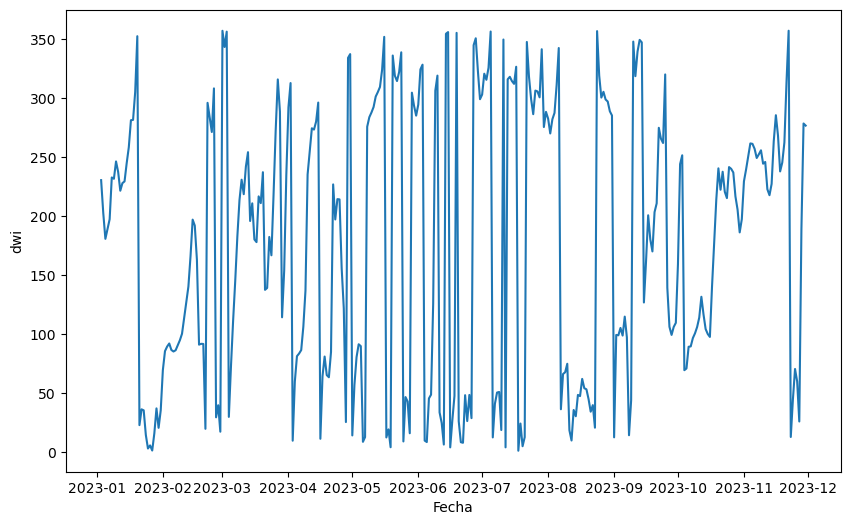

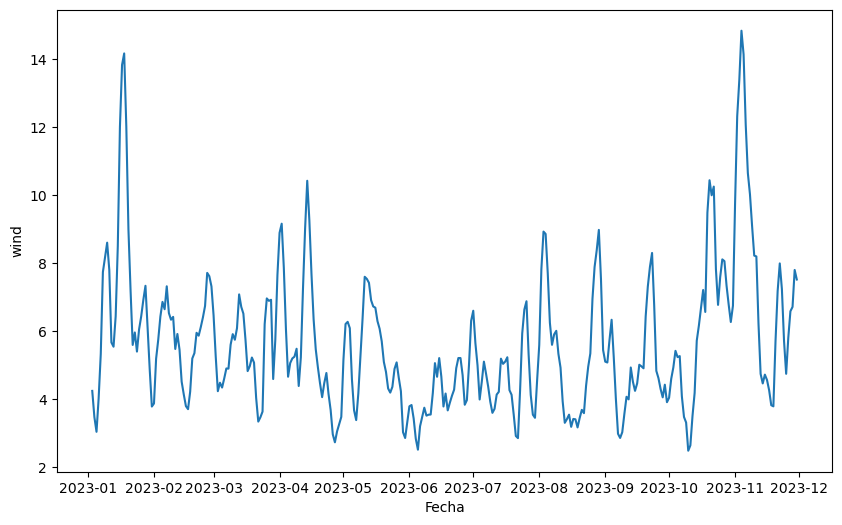

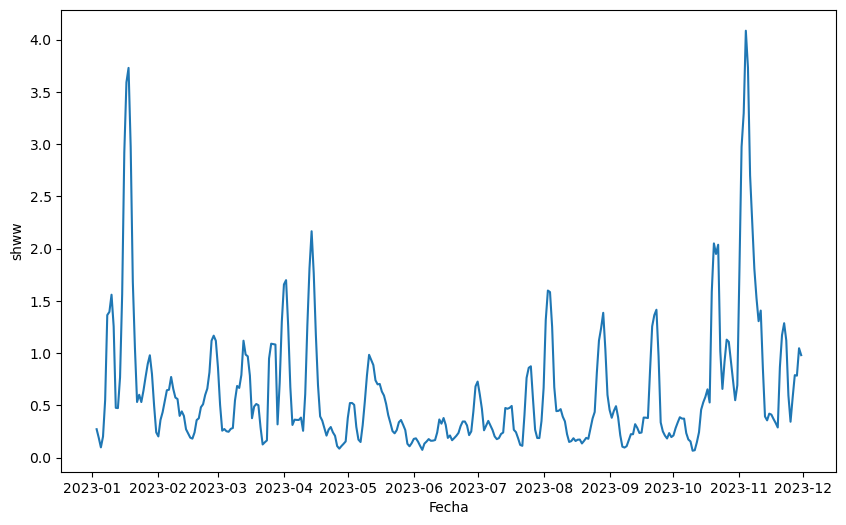

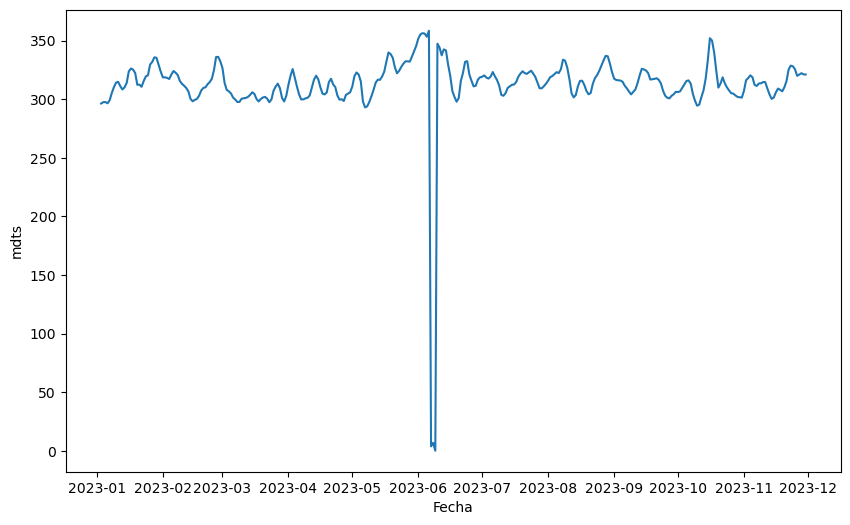

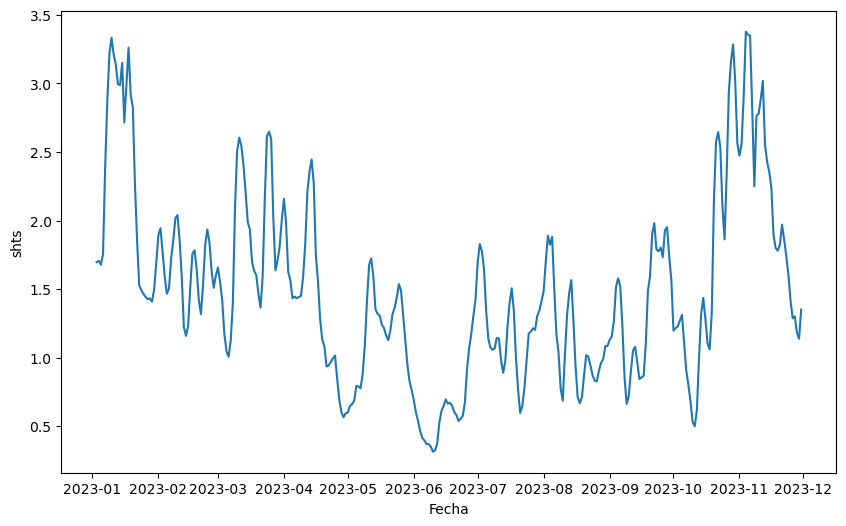

In [15]:
for var in variables_agrup:
    plt.figure(figsize=(10,6))
    plt.plot(df_espacial_4dia['date'], df_espacial_4dia[f'{var}'], label=f'{var}')
    plt.ylabel(var)
    plt.xlabel('Fecha')
    plt.show()

Otra forma mas sencilla de realizar promedios y reducciones de indices sobre el dataset es a traves de las funciones groupby. Toda variable que aparezca en groupby permanecera en el dataset, las que no aparecen seran promediadas, de esta forma, groupby(['latitude', 'longitude', 'date']) no promedia nada, df.groupby(['latitude', df['date'].dt.month]) promedia longitudinalmente y por meses y la que no tiene nada promedia las 3. Tras el uso del groupby, las columnas que no son promediadas, o lo son parcialmente pasan a ser columnas indice. Asi, sobre promedios temporales, podriamos haber usado:

In [16]:
df_espacial_horario=df.groupby(['date'])[variables_no_agrup].mean()
df_espacial_diario=df.groupby([df['date'].dt.dayofyear])[variables_no_agrup].mean()
df_espacial_mensual=df.groupby([df['date'].dt.month])[variables_no_agrup].mean()
df_espacial_temporal=df[variables_no_agrup].mean() #promedio sobre los 3 indices, tiempo, longuitud y latitud


df_espacial_horario.reset_index(inplace=True)
df_espacial_diario.reset_index(inplace=True)
df_espacial_mensual.reset_index(inplace=True)


Otro ejercicio interesante podria ser el de intentar calcular los valores maximos de las variables numericas, asi como el dia en el que sucedieron. Tambien podemos tratar de calcular cual es el mes que mayores valores se registraron, como ejemplo de su uso sobre series con otra escala temporal.

In [17]:
max_wind = df['wind'].max()
max_shww = df['shww'].max()
max_shts = df['shts'].max()

max_wind_day = df.loc[df['wind'] == max_wind, ['date', 'wind']]
max_shww_day = df.loc[df['shww'] == max_shww, ['date', 'shww']]
max_shts_day = df.loc[df['shts'] == max_shts, ['date', 'shts']]

print("Fecha y valor máximo horario de 'wind':\n", max_wind_day.to_string(index=False))
print("Fecha y valor máximo horario de 'shww':\n", max_shww_day.to_string(index=False))
print("Fecha y valor máximo horario de 'shts':\n", max_shts_day.to_string(index=False))



Fecha y valor máximo horario de 'wind':
       date      wind
2023-11-03 24.574219
Fecha y valor máximo horario de 'shww':
                date    shww
2023-11-05 03:00:00 9.14318
Fecha y valor máximo horario de 'shts':
                date     shts
2023-11-03 21:00:00 6.513699


In [18]:
max_wind = df_espacial_mensual['wind'].max()
max_shww = df_espacial_mensual['shww'].max()
max_shts = df_espacial_mensual['shts'].max()

max_wind_day = df_espacial_mensual.loc[df_espacial_mensual['wind'] == max_wind, ['date', 'wind']]
max_shww_day = df_espacial_mensual.loc[df_espacial_mensual['shww'] == max_shww, ['date', 'shww']]
max_shts_day = df_espacial_mensual.loc[df_espacial_mensual['shts'] == max_shts, ['date', 'shts']]

print("Fecha y valor máximo mensual de 'wind':\n", max_wind_day.to_string(index=False))
print("Fecha y valor máximo mensual de 'shww':\n", max_shww_day.to_string(index=False))
print("Fecha y valor máximo mensual de 'shts':\n", max_shts_day.to_string(index=False))

Fecha y valor máximo mensual de 'wind':
  date     wind
   12 8.754084
Fecha y valor máximo mensual de 'shww':
  date     shww
   11 1.333268
Fecha y valor máximo mensual de 'shts':
  date     shts
    1 2.257397


-Estudio de la serie temporal y espacial

Al mismo tiempo que estudiamos la serie temporal de las variables, podemos estuadiar la distribucion espacial de las mismas. Para ello, podemos hacer uso de la agrupacion por latitudes o longitudes, usando la funcion groupby. Atendiendo a la descripcion anterior sobre esta funcion, podemos contruir las siguientes series, que realizan todas las combinaciones basicas de promedios espaciales y temporales:

In [19]:

df['date'] = pd.to_datetime(df['date'])

df_ejemplo=df.groupby(['latitude', 'longitude', 'date'])[variables_no_agrup].mean() 
df_ejemplo=df.groupby(['latitude', 'longitude', df['date'].dt.dayofyear])[variables_no_agrup].mean() 
df_ejemplo=df.groupby(['latitude', 'longitude', df['date'].dt.month])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['latitude', 'longitude'])[variables_no_agrup].mean()

df_ejemplo=df.groupby(['latitude', 'date'])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['latitude', df['date'].dt.dayofyear])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['latitude', df['date'].dt.month])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['latitude'])[variables_no_agrup].mean()

df_ejemplo=df.groupby(['longitude', 'date'])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['longitude', df['date'].dt.dayofyear])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['longitude', df['date'].dt.month])[variables_no_agrup].mean()
df_ejemplo=df.groupby(['longitude'])[variables_no_agrup].mean()

df_ejemplo=df.groupby(['date'])[variables_no_agrup].mean()
df_ejemplo=df.groupby([df['date'].dt.dayofyear])[variables_no_agrup].mean()
df_ejemplo=df.groupby([df['date'].dt.month])[variables_no_agrup].mean()

df_ejemplo.reset_index(inplace=True)

df_ejemplo=df[variables_no_agrup].mean()

print(df_ejemplo)



cos_dwi     0.112155
sin_dwi    -0.050091
wind        5.657169
shww        0.635318
cos_mdts    0.665641
sin_mdts   -0.660902
shts        1.494781
dtype: float64


Por ejemplo, un caso mas complejo podria tratar por determinar si en la zona que esta mas cerca de la costa los valores de viento y mar son mayores o menores que mar adentro. Para ello podriamos construir las siguientes series temporales:

In [20]:
lat_corte=43.6

df_lat=df.groupby([lambda x: 'mar_adentro' if df.loc[x, 'latitude'] > lat_corte else 'costa', 'date'])[variables_no_agrup].mean()
df_lat=df.groupby([lambda x: 'mar_adentro' if df.loc[x, 'latitude'] > lat_corte else 'costa', df['date'].dt.dayofyear])[variables_no_agrup].mean()
df_lat=df.groupby([lambda x: 'mar_adentro' if df.loc[x, 'latitude'] > lat_corte else 'costa', df['date'].dt.month])[variables_no_agrup].mean()
df_lat=df.groupby([lambda x: 'mar_adentro' if df.loc[x, 'latitude'] > lat_corte else 'costa'])[variables_no_agrup].mean() 


Tomando el promedio longuitudinal y temporal total para ['wind', 'shww', 'shts'], podemos ver que:

In [21]:
df_lat=df.groupby([lambda x: 'mar_adentro' if df.loc[x, 'latitude'] > lat_corte else 'costa'])[['wind', 'shww', 'shts']].mean() 
print(df_lat)

                 wind      shww      shts
costa        5.278728  0.521848  1.333540
mar_adentro  6.035610  0.748789  1.656023


Puede verse que los valores de viento y mar son mas altos mar adentro, como podria ser esperable. 
Asi, podemos realizar el promedio temporal del dataset, manteniendo las variables espaciales, para realizar asi un mapa espacial para cada variable, lo cual puede darnos informacion sobre que areas presentan en promedio mayores valores en sus variables.

In [22]:
df_temporal=df.groupby(['latitude', 'longitude'])[variables_no_agrup].mean()


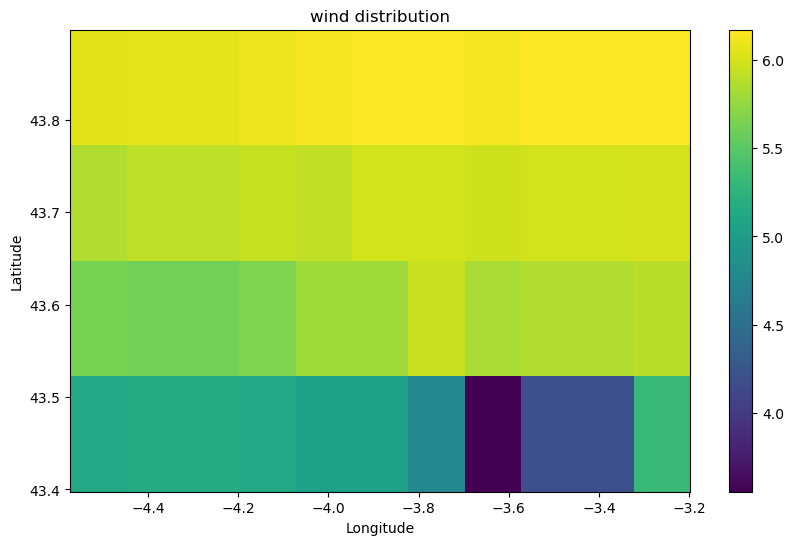

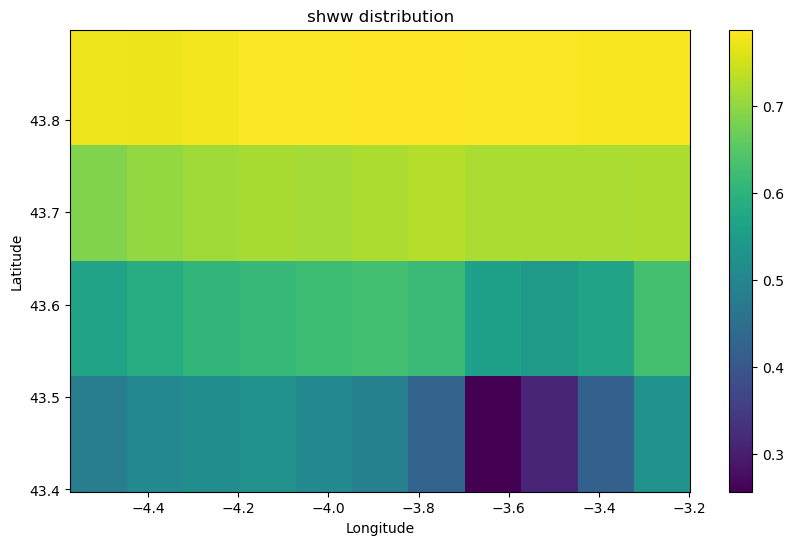

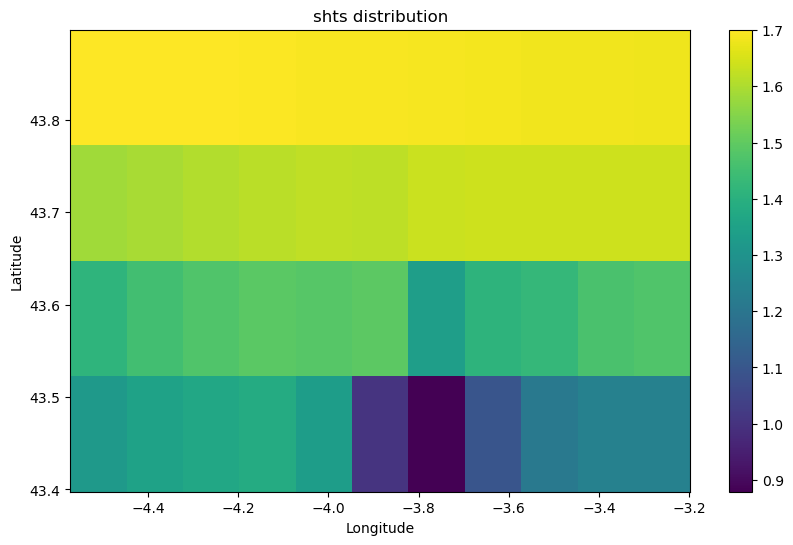

In [23]:
variables_num = ['wind', 'shww', 'shts']
for var in variables_num:
    latitudes = df_temporal.index.get_level_values('latitude').unique().to_numpy()
    longitudes = df_temporal.index.get_level_values('longitude').unique().to_numpy()
    wind_values = df_temporal[f'{var}'].unstack().to_numpy()  # Asegúrate de que 'wind' es tu variable de interés

    LON, LAT = np.meshgrid(longitudes, latitudes)

    plt.figure(figsize=(10, 6))
    mesh = plt.pcolormesh(LON, LAT, wind_values, shading='auto', cmap='viridis')
    plt.colorbar(mesh)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{var}' ' distribution')
    plt.show()

df_temporal.reset_index(inplace=True)

De nuevo, se aprecia que mar adentro, los valores son mas altos debido a la desprotección  de la costa. 
Por ultimo, podriamos tratar de calcular cual es la localizacion de los maximos de las variables numericas anteriores, ya sea en escala horaria o con un promedio temporal anual.

In [24]:
max_wind = df['wind'].max()
max_shww = df['shww'].max()
max_shts = df['shts'].max()

max_wind_day = df.loc[df['wind'] == max_wind, ['latitude', 'longitude', 'wind']]
max_shww_day = df.loc[df['shww'] == max_shww, ['latitude', 'longitude', 'shww']]
max_shts_day = df.loc[df['shts'] == max_shts, ['latitude', 'longitude', 'shts']]

print("Fecha y valor máximo horario de 'wind':\n", max_wind_day.to_string(index=False))
print("Fecha y valor máximo horario de 'shww':\n", max_shww_day.to_string(index=False))
print("Fecha y valor máximo horario de 'shts':\n", max_shts_day.to_string(index=False))

Fecha y valor máximo horario de 'wind':
  latitude  longitude      wind
   43.835      -3.26 24.574219
Fecha y valor máximo horario de 'shww':
  latitude  longitude    shww
   43.835      -3.51 9.14318
Fecha y valor máximo horario de 'shts':
  latitude  longitude     shts
    43.71      -3.26 6.513699


In [25]:
max_wind = df_temporal['wind'].max()
max_shww = df_temporal['shww'].max()
max_shts = df_temporal['shts'].max()

max_wind_day = df_temporal.loc[df_temporal['wind'] == max_wind, ['latitude', 'longitude', 'wind']]
max_shww_day = df_temporal.loc[df_temporal['shww'] == max_shww, ['latitude', 'longitude', 'shww']]
max_shts_day = df_temporal.loc[df_temporal['shts'] == max_shts, ['latitude', 'longitude', 'shts']]

print("Fecha y valor máximo mensual de 'wind':\n", max_wind_day.to_string(index=False))
print("Fecha y valor máximo mensual de 'shww':\n", max_shww_day.to_string(index=False))
print("Fecha y valor máximo mensual de 'shts':\n", max_shts_day.to_string(index=False))

Fecha y valor máximo mensual de 'wind':
  latitude  longitude     wind
   43.835      -3.26 6.169188
Fecha y valor máximo mensual de 'shww':
  latitude  longitude     shww
   43.835      -3.76 0.787698
Fecha y valor máximo mensual de 'shts':
  latitude  longitude     shts
   43.835      -4.51 1.700804


-Estudio discreto frecuentista

Como hemos visto, la descripcion de la direccionalidad de los campos es muy pobre, debido a que una media no refleja ni la composicion del espectro. Para solucionarlo, podemos definir unos umbrales direccionales basados en las 8 direcciones principales ['Norte', 'Noreste', 'Este', 'Sureste', 'Sur', 'Suroeste', 'Oeste', 'Noroeste'] y clasificar cada medida en una de estas 8 en cada una de las coordenadas espaciales y temporales. 
Este análisis tambien es util para las demas variables. Al tratar las variables meteorologicas maritimas, existen unas escalas muy utilizadas que permite desglosar el estado del viento y el mar de forma sencilla, sin tener que dar con precision el numero exacto. Estas son la escala Beaufort (Viento) y la escala Douglas (Mar de viento), pudiendo tomar ciertos valores discretos. Asi podemos utilizar este mismo principio para determinar el histograma de las distintas escalas para cada dato. Para el mar de fondo no existe una escala propia, pudiendo agruparse por numeros enteros en la altura significativa del mar. 

In [26]:
reconstruir_angulo(df, 'dwi')
reconstruir_angulo(df, 'mdts')

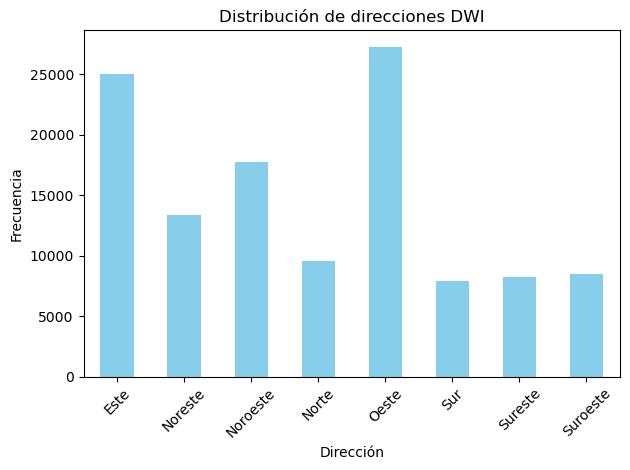

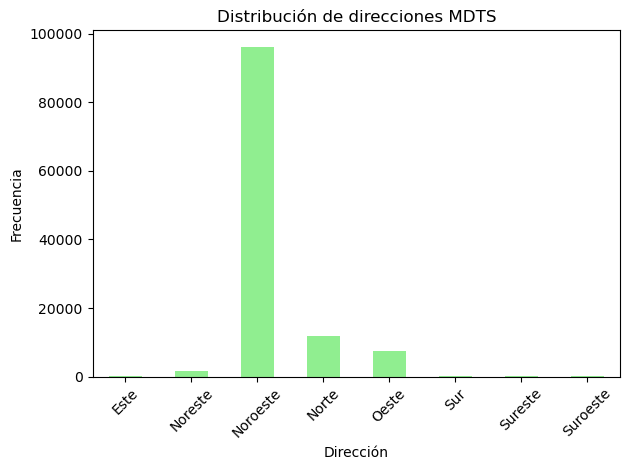

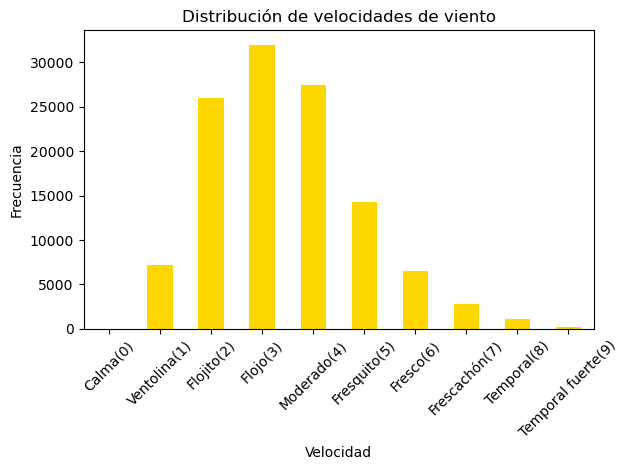

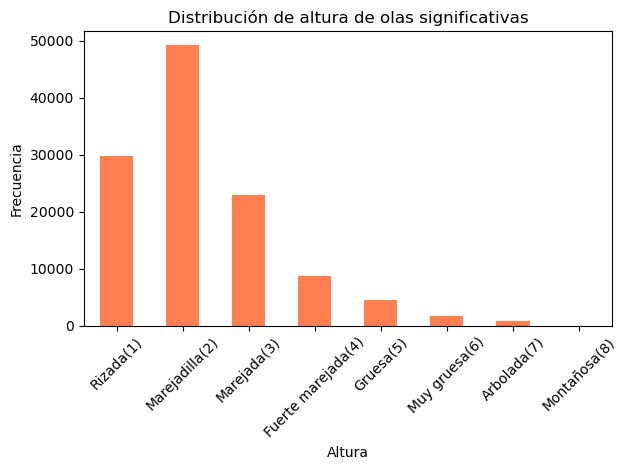

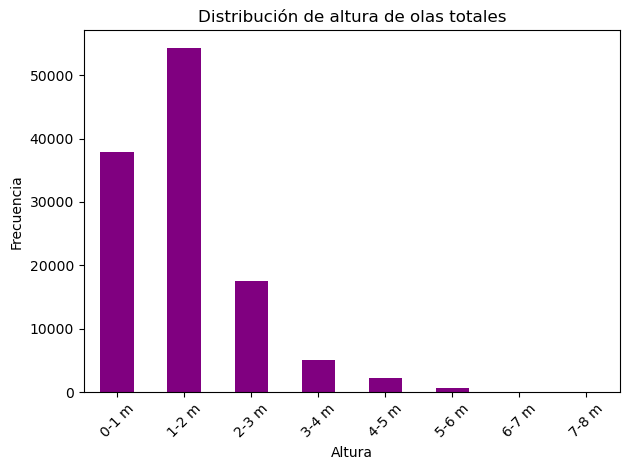

In [27]:
#Taodavia no este promediando en espacio

bins_dir = [0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360]
labels_dir = ['Norte', 'Noreste', 'Este', 'Sureste', 'Sur', 'Suroeste', 'Oeste', 'Noroeste', 'Norte']
bins_wind = [0, 0.2, 1.5, 3.3, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4]
labels_wind = ['Calma(0)', 'Ventolina(1)', 'Flojito(2)', 'Flojo(3)', 'Moderado(4)', 'Fresquito(5)', 'Fresco(6)', 'Frescachón(7)', 'Temporal(8)', 'Temporal fuerte(9)']
bins_shww = [0, 0.1, 0.5, 1.25, 2.5, 4, 6, 9, 14]
labels_shww = ['Rizada(1)', 'Marejadilla(2)', 'Marejada(3)', 'Fuerte marejada(4)', 'Gruesa(5)', 'Muy gruesa(6)', 'Arbolada(7)', 'Montañosa(8)']
bins_shts = [0, 1, 2, 3, 4, 5, 6, 7, 8]
labels_shts = ['0-1 m', '1-2 m', '2-3 m', '3-4 m', '4-5 m', '5-6 m', '6-7 m', '7-8 m']
df['dwi_hist'] = pd.cut(df['dwi'], bins=bins_dir, labels=labels_dir, right=False, ordered=False)
df['mdts_hist'] = pd.cut(df['mdts'], bins=bins_dir, labels=labels_dir, right=False, ordered=False)
df['wind_hist'] = pd.cut(df['wind'], bins=bins_wind, labels=labels_wind, right=False)
df['shww_hist'] = pd.cut(df['shww'], bins=bins_shww, labels=labels_shww, right=False)
df['shts_hist'] = pd.cut(df['shts'], bins=bins_shts, labels=labels_shts, right=False)
# Definimos una función para generar los gráficos de las columnas categorizadas
def plot_histogram(dataframe, column_name, color, title, x_label, y_label):
    dataframe[column_name].value_counts().sort_index().plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Histograma para 'dwi_hist'
plot_histogram(df, 'dwi_hist', 'skyblue', 'Distribución de direcciones DWI', 'Dirección', 'Frecuencia')

# Histograma para 'mdts_hist'
plot_histogram(df, 'mdts_hist', 'lightgreen', 'Distribución de direcciones MDTS', 'Dirección', 'Frecuencia')

# Histograma para 'wind_hist'
plot_histogram(df, 'wind_hist', 'gold', 'Distribución de velocidades de viento', 'Velocidad', 'Frecuencia')

# Histograma para 'shww_hist'
plot_histogram(df, 'shww_hist', 'coral', 'Distribución de altura de olas significativas', 'Altura', 'Frecuencia')

# Histograma para 'shts_hist'
plot_histogram(df, 'shts_hist', 'purple', 'Distribución de altura de olas totales', 'Altura', 'Frecuencia')

df.drop(['dwi_hist', 'mdts_hist','wind_hist', 'shww_hist', 'shts_hist'], axis=1, inplace=True)

-En los graficos puede verse que la direccion del viento suele ser o bien del este o bien del oeste, teniendo predileccion a rotar hacia las componentes norte adjacentes, y que sin embargo es raro que tenga componente sur, debido al hecho de que el viento no suele venir de tierra. 
-En cuanto a la direccion del mar de fondo, este suele ser del noroeste en casi todos los casos. El mar de fondo es producido por la propagacion de perturbaciones en forma de ondas por el oceano, producidas por grandes borrascas situadas lejos. Esta direccion nos indica la localizacion media de las borrascas con respecto a la zona a estudiar.
-Las distribuciones de viento, mar de fondo y mar de viento son parecidas entre si, siendo funciones sesgadas hacia la izquierda, con la moda siendo uno de los primeros valores, decayendo hacia la derecha en forma de larga cola, siendo los valores extremos cada vez mas raros

-Coeficientes de correlacion

Otro fenomeno interesante a estudiar es la posible correlacion entre las distinas variables mostradas en el dataset. Por ejemplo, es esperable una fuerte relacion entre la intensidad del viendo y el mar de viento, que es levantado por este. Para ello, tomamos el dataset completo, con los indices de tiempo longuitud y latitud completo y generamos la matriz de correlacion.

In [28]:
correlation_matrix = df[variables_agrup].corr()
print(correlation_matrix)

           dwi      wind      shww      mdts      shts
dwi   1.000000  0.207598  0.255969  0.002293  0.165341
wind  0.207598  1.000000  0.887825 -0.005702  0.321704
shww  0.255969  0.887825  1.000000 -0.003107  0.320396
mdts  0.002293 -0.005702 -0.003107  1.000000  0.118745
shts  0.165341  0.321704  0.320396  0.118745  1.000000


Asi puede verse una indice de correlacion de 0.888 entre el la intensidad del viendo y la altura del mar de viento, como hemos mencionado. Tambien existen correlaciones de segundo orden del viento y el mar de viento con el mar de fondo, debidas seguramente a que cuando una perturbacion genera mar de fondo, en muchos casos esta puede acabar azotando las costas de la peninsula, mientras que las situaciones de calma lo son en todas las variables. Sin embargo la correlacion entre la direccion del viento y la direccion del mar de fondo es casi inexistente. Para vislumbrar esto sobrepondremos los graficos de [wind, shww], [wind, shts], [shww, shts] y [dwi, mdts], tras un promedio espacial y un ligero promedio temporal a 4 dias (df_espacial_4dia), para no saturar el grafico.

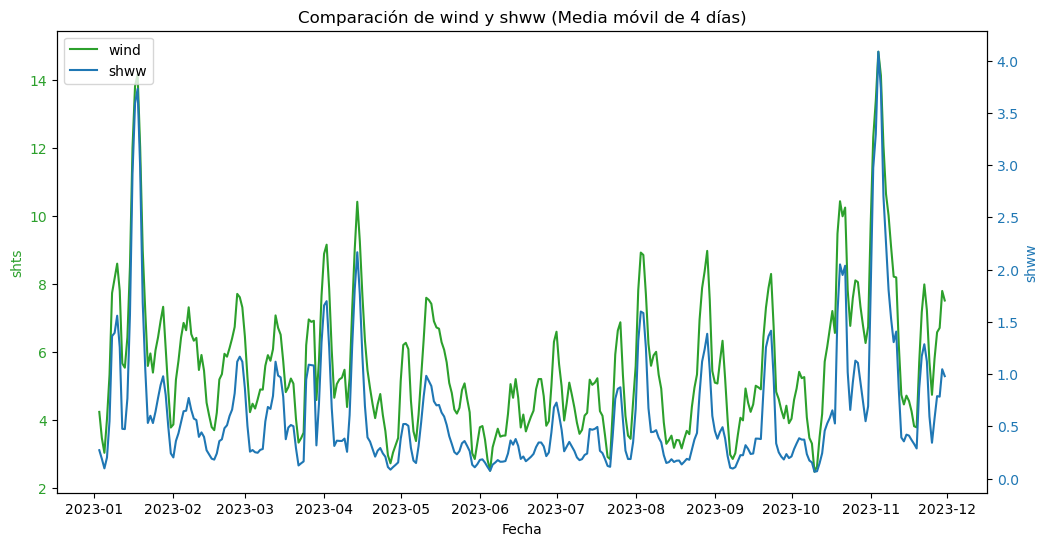

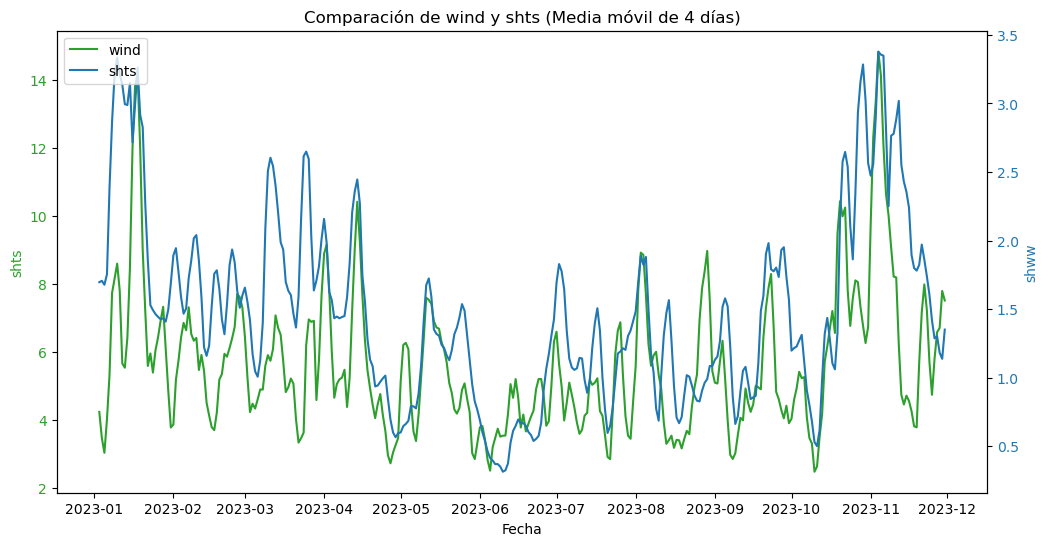

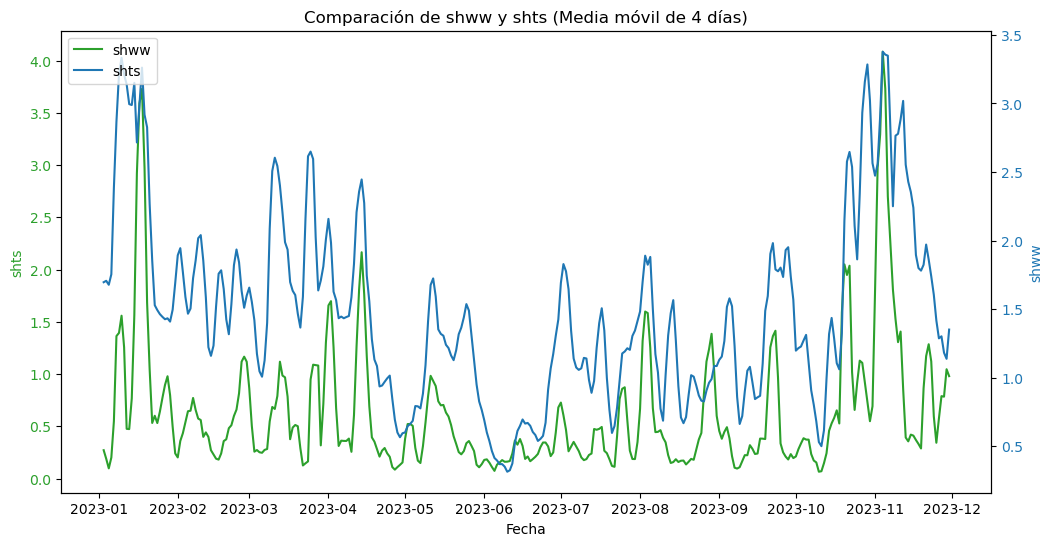

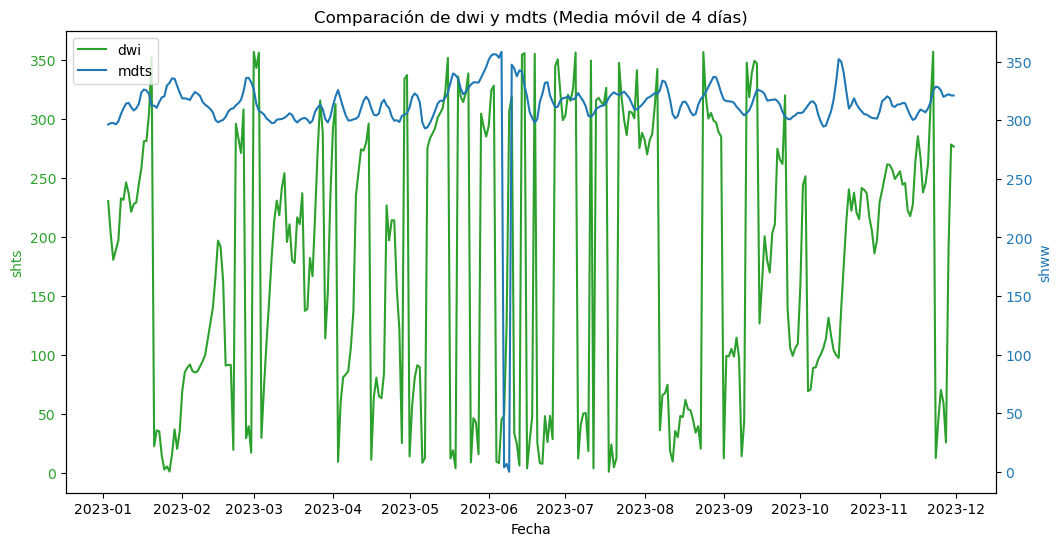

In [29]:
duplas = [['wind', 'shww'], ['wind', 'shts'], ['shww', 'shts'], ['dwi', 'mdts']]
for (a, b) in duplas:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:green'
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('shts', color=color)
    ax1.plot(df_espacial_4dia['date'], df_espacial_4dia[a], color=color, label=a)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('shww', color=color)
    ax2.plot(df_espacial_4dia['date'], df_espacial_4dia[b], color=color, label=b)
    ax2.tick_params(axis='y', labelcolor=color)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title(f'Comparación de {a} y {b} (Media móvil de 4 días)')

    plt.show()

Puede verse claramente la correspondencia entre [wind, shww], siendo el resto mas matizables

-Estudio sobre posibles avisos costeros

A la hora de salvaguardar los bienes y las salud de las personas, se han establecido umbrales de riesgo relacionados con el estado de las variables meteorologicas en las aguas costeras de España. En el caso de las costas Atlanticas, los avisos comienzan cuando se den uno de los 2 siguientes casos:
-Fuerza del viento 7 en la escala Beaufort (a partir de 50 km/h o 13.8m/s)
-Altura significativa del mar combinado de mas de 4 m.
El mar combinado surge de la adiccion vectorial del mar de viento y el mar de fondo, que en este caso no tenemos datos. Aun asi supondremos que esta caracteristica se da cuando alguno de los 2 mares supera los 4 m. Asi trataremos de identificar para que dias de 2023 se dio aviso y para cuales no, pudiendo sacar una estadistica aproximada del porcentaje dias para las cuales esto sucedio . Para que se de aviso en la zona es suficiente con que en un punto del espacio se supere alguno de los umbrales. Asi:

In [30]:
df_filtrado = df[(df['wind'] > 13.8) | (df['shww'] > 4) | (df['shts'] > 4)]

fechas_unicas = df_filtrado['date'].dt.date.unique()

recuento_fechas = len(fechas_unicas)

print(f'Número de dias de aviso: {recuento_fechas}')
#print('Fechas:', fechas_unicas)
d_aviso=58/355*100
print(f'Porcentaje de dias de aviso: {d_aviso}')

Número de dias de aviso: 58
Porcentaje de dias de aviso: 16.338028169014084


Asi, tenemos que aproximadamente en 1/6 de los dias se dio aviso, durante 2023. Si queremos ver que porcentaje dio en el medio año estival (desde abril a septiembre), o en el medio año invernal (desde octuble a marzo):

In [31]:
fechas_unicas = df_filtrado['date'].dt.date.unique()

fechas_unicas_datetime = pd.to_datetime(fechas_unicas)

meses = fechas_unicas_datetime.month

avisos_abril_septiembre = np.sum(np.isin(meses, [4, 5, 6, 7, 8, 9]))
avisos_octubre_marzo = len(meses) - avisos_abril_septiembre

total_fechas_unicas = len(fechas_unicas)
porcentaje_abril_septiembre = (avisos_abril_septiembre / total_fechas_unicas) * 100
porcentaje_octubre_marzo = (avisos_octubre_marzo / total_fechas_unicas) * 100

print(f'Porcentaje avisos de abril a septiembre: {porcentaje_abril_septiembre:.2f}%')
print(f'Porcentaje avisos de octubre a marzo: {porcentaje_octubre_marzo:.2f}%')

Porcentaje avisos de abril a septiembre: 20.69%
Porcentaje avisos de octubre a marzo: 79.31%


Asi puede verse que 4/5 de los avisos se dieron en invierno